In [986]:
import random
from collections import defaultdict
from importlib import reload

import frank_wolfe
import main_gaussian
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn import preprocessing

reload(frank_wolfe)
reload(main_gaussian)

from opendataval.dataloader import DataFetcher
from opendataval.dataval import KNNShapley
from opendataval.model import RegressionSkLearnWrapper
from sklearn.cluster import KMeans
from sklearn.random_projection import GaussianRandomProjection
from tqdm.notebook import tqdm

In [987]:
import torch
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error


def evaluate_subset(train_subset, train_x, train_y, test_x, test_y, use_ridge=False):
    if isinstance(train_x, torch.Tensor):
        train_x = train_x.numpy()
        train_y = train_y.numpy()
        test_x = test_x.numpy()
        test_y = test_y.numpy()
    if use_ridge:
        reg = Ridge(fit_intercept=False)
    else:
        reg = LinearRegression(fit_intercept=False)
    reg.fit(train_x[train_subset], train_y[train_subset])
    pred = reg.predict(test_x)
    error = mean_squared_error(test_y, pred)
    return error

In [988]:
from importlib import reload

import frank_wolfe
import main_gaussian

reload(main_gaussian)
reload(frank_wolfe)

<module 'frank_wolfe' from '/u/luchar/data-markets/frank_wolfe.py'>

In [989]:
from sklearn.datasets import load_diabetes, make_regression

In [1028]:
reload(utils)

N = 10000
D = 30 
x, y, beta = make_regression(
    n_samples=N,
    n_features=D,
    # n_informative=D//2,
    n_informative=D,
    n_targets=1,
    bias=1,
    noise=0.1,
    coef=True,
)

# x, y, beta = utils.get_news_data(num=N, dim=D).values()
# print(x.shape)

n_buy = 1
x_buy = x[:n_buy]
x_sell = x[n_buy:]
y_buy = x_buy @ beta
y_sell = y[n_buy:]


n_train = 10
beta_pred = np.linalg.pinv(x_sell[:n_train]).dot(y_sell[:n_train])
print((x_buy.dot(beta_pred) - y_buy) ** 2)
evaluate_subset(range(10), x_sell, y_sell, x_buy, y_buy)

[74.3650339]


74.36503390216016

In [1029]:
x.shape

(10000, 30)

In [1030]:
reload(main_gaussian)
results = main_gaussian.design_selection(
    (x_sell, y_sell),
    (x_buy, y_buy),
    num_iters=100,
    num_select=D,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 309.80it/s]


In [1031]:
# results['coords']

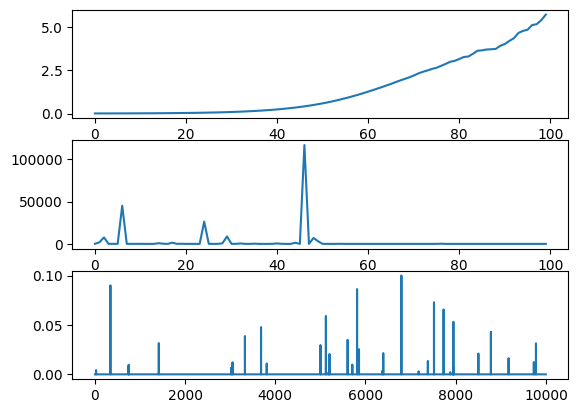

In [1032]:
fig, ax = plt.subplots(3)
ax[0].plot(results["losses"].values())
ax[1].plot(results["errors"].values())
ax[2].plot(results["weights"])

In [1033]:
num_val = 100
model = RegressionSkLearnWrapper(LinearRegression)
fetcher = DataFetcher.from_data_splits(
        x_sell[num_val:], y_sell[num_val:], x_sell[:num_val], y_sell[:num_val], x_sell[:num_val], y_sell[:num_val], one_hot=False
)
knn = KNNShapley().train(fetcher=fetcher, pred_model=model).data_values

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9898/9898 [00:01<00:00, 6406.02it/s]


In [1034]:
(results["weights"] > 0.01).sum()

23

In [1035]:
# get_error(our_select_sampled(size=50), x_sell, y_sell, x_buy, y_buy)

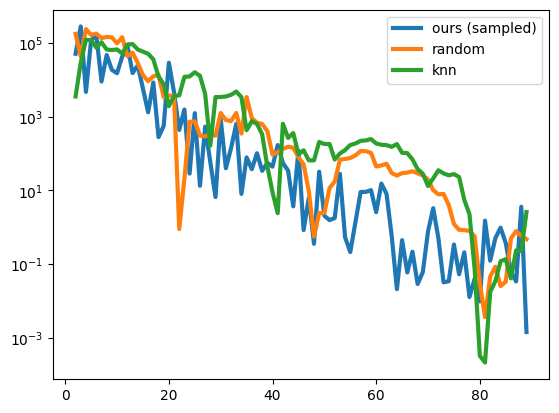

In [1036]:
our_select_fixed = results["weights"].argsort()
our_select_sampled = partial(
    np.random.choice, np.arange(len(x_sell)), p=results["weights"], replace=False
)
random_select = np.random.permutation(len(x_sell))
knn_select = knn.argsort()

# select = range(5)
def get_error(select, x_sell, y_sell, x_buy, y_buy):
    # LR = LinearRegression()
    LR = Ridge()
    LR.fit(x_sell[select], y_sell[select])
    pred = LR.predict(x_buy)
    return mean_squared_error(pred, y_buy)


# r = range(2, 120)
r = range(2, 3* D )
# plt.plot(
#     r,
#     [get_error(our_select_fixed[-j:], x_sell, y_sell, x_buy, y_buy) for j in r],
#     label="ours (fixed)",
#     lw=3,
#     c="C0",
# )
plt.plot(r, [get_error(our_select_sampled(size=j), x_sell, y_sell, x_buy, y_buy) for j in r], label='ours (sampled)', lw=3, c='C0', ls='-')
plt.plot(r, [get_error(random_select[:j], x_sell, y_sell, x_buy, y_buy) for j in r], label='random', lw=3, c='C1')
plt.plot(
    r,
    [get_error(knn_select[-j:], x_sell, y_sell, x_buy, y_buy) for j in r],
    label="knn",
    lw=3,
    c="C2",
)
# plt.ylim(0, 100)
plt.legend()
plt.yscale('log')

In [674]:
beta_pred = np.linalg.pinv(x_sell[select]).dot(y_sell[select])
(x_buy.dot(beta_pred) - y_buy) ** 2

array([2833.38236092])

In [669]:
C = np.dot(x_sell.T, x_sell)
inv_cov = np.linalg.inv(C)
np.linalg.cond(C)

1.1306492906342624

In [524]:
neg_grad[coord]

6.136556089903284e-06

In [480]:
inv_cov
loss = frank_wolfe.compute_exp_design_loss(x_buy, inv_cov)
loss

0.0031602355062126403

In [481]:
neg_grad = frank_wolfe.compute_neg_gradient(x_sell, x_buy, inv_cov)
neg_grad

array([3.42117449e-07, 1.94158957e-07, 2.25579120e-08, ...,
       1.38291143e-06, 6.89690260e-07, 4.79272357e-08])

In [482]:
coord = np.argmax(neg_grad)
print(
    f"{neg_grad[coord] = }",
    f"{cosine_similarity(x_buy, x_sell[coord].reshape(1, -1)) = }",
    sep="\n",
)

neg_grad[coord] = 6.136556089903284e-06
cosine_similarity(x_buy, x_sell[coord].reshape(1, -1)) = array([[-0.60745506]])


In [483]:
beta_pred = np.linalg.pinv(x_sell[19, np.newaxis]).dot(y_sell[19])
(x_buy.dot(beta_pred) - y_buy) ** 2

array([[32631.99278149]])

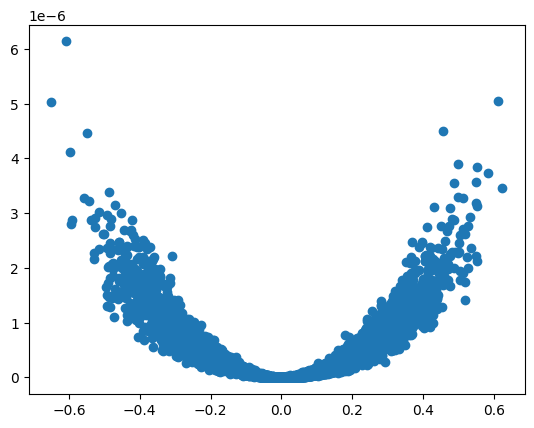

In [484]:
plt.scatter(cosine_similarity(x_buy, x_sell), neg_grad)

In [40]:
def design_selection(
    seller_data,
    buyer_data,
    num_select=100,
    num_iters=100,
    alpha=0.1,
    line_search=False,
    scale_cov=False,
    topk=1,
):
    x_sell, y_sell = seller_data
    x_buy, y_buy = buyer_data

    # initialize seller weights
    n_sell = x_sell.shape[0]
    # weights = np.ones(n_sell) * n_sell
    weights = np.ones(n_sell) / n_sell
    # weights = np.ones(n_sell) * num_iters
    # weights = np.ones(n_sell)

    def scale(cov):
        cov -= cov.min()
        return cov / (cov.max() - cov.min())

    # inverse covariance matrix
    # inv_cov = np.linalg.pinv(x_sell.T @ (np.diag(weights)) @ x_sell)
    # inv_cov = np.eye(x_sell.shape[1])
    inv_cov = np.linalg.pinv(np.dot(x_sell.T, x_sell))

    # if scale_cov:
    #     inv_cov = scale(
    #         inv_cov
    #     )  # rescale inverse covariance matrix to be between 0 and 1

    # experimental design loss i.e. E[X_buy.T @ inv_cov @ X]
    loss = frank_wolfe.compute_exp_design_loss(x_buy, inv_cov)

    # track losses and errors
    coords = {}
    losses = {}
    errors = {}
    norms = {}
    conds = {}
    alphas = {}

    for i in tqdm(range(num_iters)):
        # Pick coordinate with largest gradient to update
        neg_grad = frank_wolfe.compute_neg_gradient(x_sell, x_buy, inv_cov)

        if topk > 1:
            sorted_grad = neg_grad.argsort()[::-1]
            update_coord = sorted_grad[:topk]
            coords[i] = update_coord
        else:
            update_coord = np.argmax(neg_grad)
            coords[i] = update_coord

        if line_search:
            alpha, loss = frank_wolfe.opt_step_size(
                x_sell[update_coord], x_buy, inv_cov, loss
            )

        weights *= 1 - alpha
        weights[update_coord] += alpha

        # inv_cov = np.linalg.pinv(x_sell.T @ np.diag(weights) @ x_sell)

        inv_cov /= 1 - alpha
        if topk > 1:
            for coord in update_coord:
                inv_cov = frank_wolfe.sherman_morrison_update_inverse(
                    inv_cov,
                    alpha * x_sell[coord, :],
                    x_sell[coord, :],
                )
        else:
            inv_cov = frank_wolfe.sherman_morrison_update_inverse(
                inv_cov,
                alpha * x_sell[update_coord, :],
                x_sell[update_coord, :],
            )

        if scale_cov:
            inv_cov = scale(inv_cov)

        selected_seller_indices = np.random.choice(
            np.arange(weights.shape[0]),
            size=num_select,
            p=weights / weights.sum(),
            replace=False,
        )
        results = frank_wolfe.evaluate_indices(
            x_sell,
            y_sell,
            x_buy,
            y_buy,
            selected_seller_indices,
            inverse_covariance=inv_cov,
        )
        exp_loss = frank_wolfe.compute_exp_design_loss(x_buy, inv_cov)
        # losses[i] = results["exp_loss"]
        losses[i] = exp_loss
        errors[i] = results["mse_error"]
        norms[i] = np.linalg.norm(inv_cov, ord="fro")
        conds[i] = np.linalg.cond(x_sell.T @ np.diag(weights) @ x_sell)
        alphas[i] = alpha
    # weights /= weights.sum()
    return dict(
        losses=losses,
        errors=errors,
        weights=weights,
        norms=norms,
        conds=conds,
        coords=coords,
        alphas=alphas,
        sell=(x_sell, y_sell),
        buy=(x_buy, y_buy),
        val=(x_val, y_val),
    )

In [41]:
noise_level = 0.5
num_buyer = 1
num_seller = 1000
dim = 20

dim = 10
x_s1 = np.random.normal(size=(num_seller, dim))
x_s1 /= np.linalg.norm(x_s1, axis=1, keepdims=True)
beta_true = np.random.exponential(scale=1, size=dim)
beta_true *= np.sign(np.random.random(size=dim))
y_s1 = x_s1 @ beta_true + noise_level * np.random.randn(num_seller)
x_b1 = np.random.normal(size=[num_buyer, dim])
x_b1 /= np.linalg.norm(x_b1, axis=1, keepdims=True)
y_b1 = x_b1 @ beta_true

dim = 50
x_s2 = np.random.normal(size=(num_seller, dim))
x_s2 /= np.linalg.norm(x_s2, axis=1, keepdims=True)
beta_true = np.random.exponential(scale=1, size=dim)
beta_true *= np.sign(np.random.random(size=dim))
y_s2 = x_s2 @ beta_true + noise_level * np.random.randn(num_seller)
x_b2 = np.random.normal(size=[num_buyer, dim])
x_b2 /= np.linalg.norm(x_b2, axis=1, keepdims=True)
y_b2 = x_b2 @ beta_true

dim = 200
x_s3 = np.random.normal(size=(num_seller, dim))
x_s3 /= np.linalg.norm(x_s3, axis=1, keepdims=True)
beta_true = np.random.exponential(scale=1, size=dim)
beta_true *= np.sign(np.random.random(size=dim))
y_s3 = x_s3 @ beta_true + noise_level * np.random.randn(num_seller)
x_b3 = np.random.normal(size=[num_buyer, dim])
x_b3 /= np.linalg.norm(x_b3, axis=1, keepdims=True)
y_b3 = x_b3 @ beta_true

num_seller = 100
dim = 10
x_s4 = np.random.normal(size=(num_seller, dim))
x_s4 /= np.linalg.norm(x_s4, axis=1, keepdims=True)
beta_true = np.random.exponential(scale=1, size=dim)
beta_true *= np.sign(np.random.random(size=dim))
y_s4 = x_s4 @ beta_true + noise_level * np.random.randn(num_seller)
x_b4 = np.random.normal(size=[num_buyer, dim])
x_b4 /= np.linalg.norm(x_b4, axis=1, keepdims=True)
y_b4 = x_b4 @ beta_true

num_seller = 5000
dim = 100
x_s5 = np.random.normal(size=(num_seller, dim))
x_s5 /= np.linalg.norm(x_s5, axis=1, keepdims=True)
beta_true = np.random.exponential(scale=1, size=dim)
beta_true *= np.sign(np.random.random(size=dim))
y_s5 = x_s5 @ beta_true + noise_level * np.random.randn(num_seller)
x_b5 = np.random.normal(size=[num_buyer, dim])
x_b5 /= np.linalg.norm(x_b5, axis=1, keepdims=True)
y_b5 = x_b5 @ beta_true

num_seller = 10000
dim = 100
x_s6 = np.random.normal(size=(num_seller, dim))
x_s6 /= np.linalg.norm(x_s6, axis=1, keepdims=True)
beta_true = np.random.exponential(scale=1, size=dim)
beta_true *= np.sign(np.random.random(size=dim))
y_s6 = x_s6 @ beta_true + noise_level * np.random.randn(num_seller)
x_b6 = np.random.normal(size=[num_buyer, dim])
x_b6 /= np.linalg.norm(x_b6, axis=1, keepdims=True)
y_b6 = x_b6 @ beta_true

In [42]:
from sklearn.metrics.pairwise import cosine_similarity

In [43]:
# np.linalg.cond(np.dot(x_sell.T, x_sell))

In [44]:
g1 = frank_wolfe.compute_neg_gradient(x_s1, x_b1, np.linalg.pinv(np.dot(x_s1.T, x_s1)))

g2 = frank_wolfe.compute_neg_gradient(x_s2, x_b2, np.linalg.pinv(np.dot(x_s2.T, x_s2)))

g3 = frank_wolfe.compute_neg_gradient(x_s3, x_b3, np.linalg.pinv(np.dot(x_s3.T, x_s3)))

g4 = frank_wolfe.compute_neg_gradient(x_s4, x_b4, np.linalg.pinv(np.dot(x_s4.T, x_s4)))

g5 = frank_wolfe.compute_neg_gradient(x_s5, x_b5, np.linalg.pinv(np.dot(x_s5.T, x_s5)))
g6 = frank_wolfe.compute_neg_gradient(x_s6, x_b6, np.linalg.pinv(np.dot(x_s6.T, x_s6)))

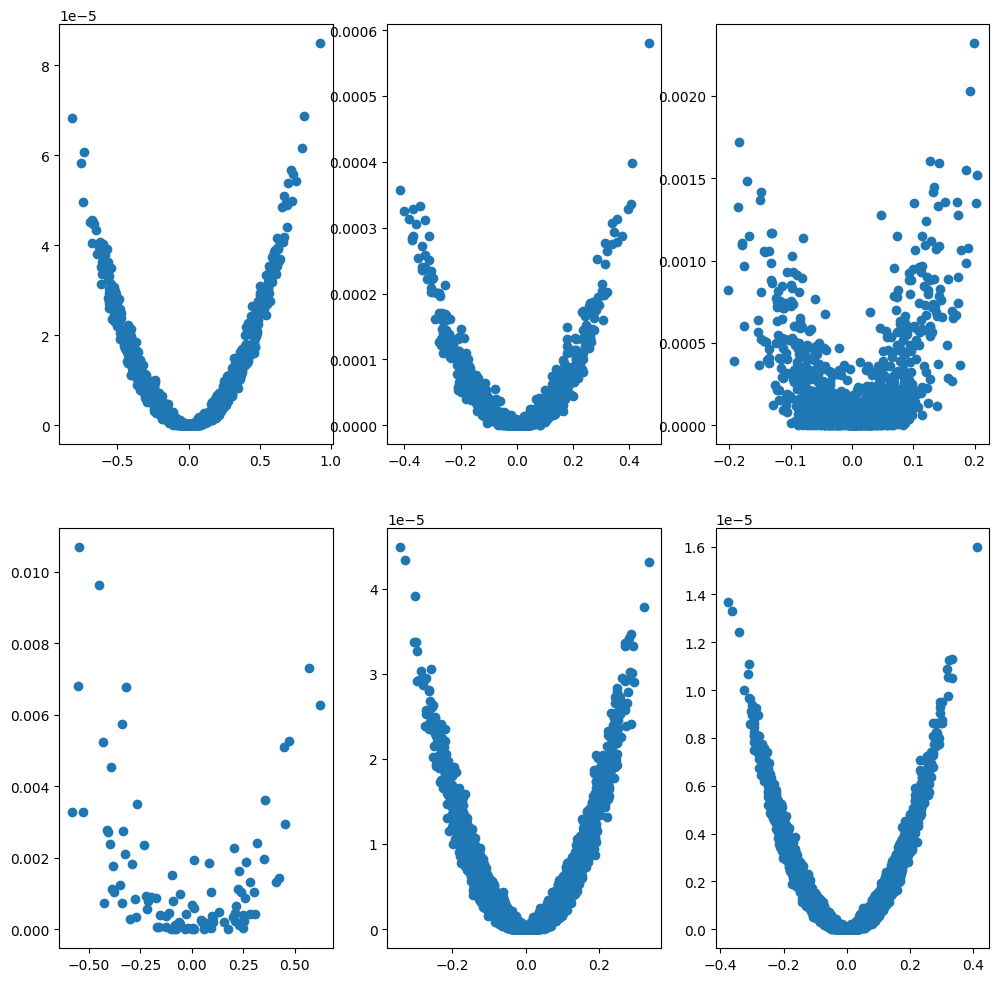

In [45]:
fig, axes = plt.subplots(figsize=(12, 12), nrows=2, ncols=3)
axes[0, 0].scatter(
    cosine_similarity(x_b1, x_s1),
    g1,
)
axes[0, 1].scatter(
    cosine_similarity(x_b2, x_s2),
    g2,
)
axes[0, 2].scatter(
    cosine_similarity(x_b3, x_s3),
    g3,
)
axes[1, 0].scatter(
    cosine_similarity(x_b4, x_s4),
    g4,
)
axes[1, 1].scatter(
    cosine_similarity(x_b5, x_s5),
    g5,
)
axes[1, 2].scatter(
    cosine_similarity(x_b6, x_s6),
    g6,
)

In [161]:
from importlib import reload

import utils

reload(utils)

<module 'utils' from '/u/luchar/data-markets/utils.py'>

In [180]:
exp_trials = 5
num_buyer = 1
reload(main_gaussian)

gauss_buy_res = defaultdict(list)
gauss_sell_res = defaultdict(list)
gauss_val_res = defaultdict(list)
gauss_weight_res = defaultdict(list)
gauss_cond_res = defaultdict(list)
gauss_norm_res = defaultdict(list)
gauss_loss_res = defaultdict(list)
gauss_coord_res = defaultdict(list)
gauss_err_res = defaultdict(list)
# for k in [0.1, 0.5, 1, 5]:
# for k in [1, 5, 10, 20]:
# for k in [10, 50, 100, 500]:
for k in [100, 500, 1000, 5000, 10000]:
    print(k)
    for i in range(exp_trials):
        # x_sell, y_sell, x_val, y_val, x_buy, y_buy, beta = main_gaussian.get_data(
        x_sell, y_sell, x_val, y_val, x_buy, y_buy, beta = utils.get_data(
            num_seller=k,
            num_buyer=5,
            dim=30,
            num_seller_subset=0,
            buyer_subset=False,
            noise_level=0.1,
            return_beta=True,
            random_seed=i,
            bone_data=False,
            # bone_data=True,
            # exponential=True,
        )
        # P = GaussianRandomProjection(n_components=10)
        # x_proj = P.fit_transform(np.concatenate([x_sell, x_buy]))
        # x_sell_proj = x_proj[:x_sell.shape[0]]
        # x_buy_proj = x_proj[x_sell.shape[0]:]

        res = main_gaussian.design_selection(
            # (x_sell_proj, y_sell), (x_buy_proj, y_buy),
            (x_sell, y_sell),
            (x_buy, y_buy),
            num_select=10,
            # num_iters=100,
            num_iters=100,
            alpha=0.1,
            # scale_cov=True,
            # scale_cov=False,
            # shrink=False,
        )
        gauss_loss_res[k].append(res["losses"])
        # norm_res[k].append(res['norms'])
        # cond_res[k].append(res['conds'])
        gauss_err_res[k].append(res["errors"])
        # coord_res[k].append(res['coords'])
        gauss_weight_res[k].append(res["weights"])
        gauss_buy_res[k].append((x_buy, y_buy))
        gauss_sell_res[k].append((x_sell, y_sell))
        gauss_val_res[k].append((x_val, y_val))

100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1003.80it/s]


500


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 829.80it/s]


1000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 773.92it/s]


5000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 435.54it/s]


10000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 304.10it/s]


ValueError: x and y must be the same size

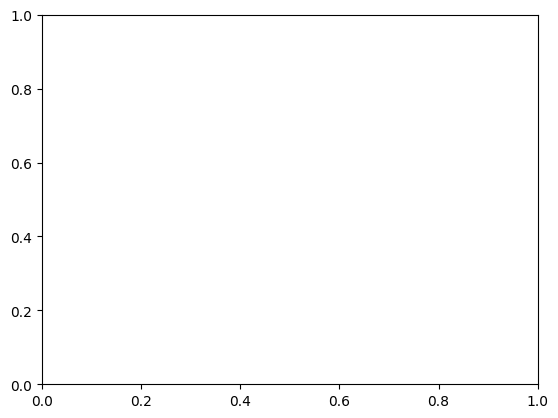

In [163]:
k = list(gauss_buy_res.keys())[0]
for j in range(exp_trials):
    # j = 0
    plt.scatter(
        cosine_similarity(gauss_buy_res[k][j][0], gauss_sell_res[k][j][0]),
        gauss_weight_res[k][j],
    )
    plt.xlabel("Cosine sim. between buyer and seller")
    plt.ylabel("Gradient magnitude")

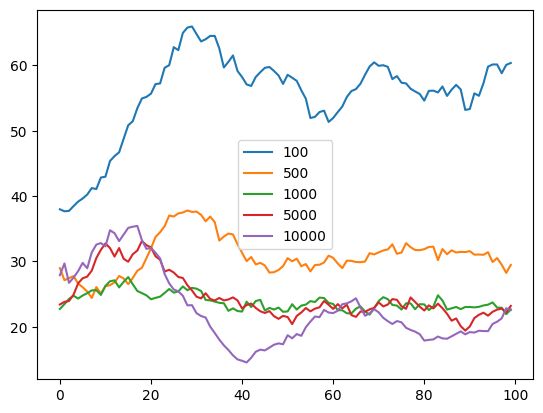

In [181]:
for k in list(gauss_buy_res.keys()):
    plt.plot(
        np.mean(
            [
                list(gauss_loss_res[k][i].values())
                for i in range(len(gauss_loss_res[k]))
            ],
            0,
        ),
        label=k,
    )
    # plt.plot(np.mean([list(gauss_err_res[k][i].values()) for i in range(len(gauss_err_res[k]))], 0), label=k)
# plt.xlim(0, 50)
# plt.ylim(0, 100)
plt.legend()

In [182]:
base_trials = 5
gauss_base_weights = defaultdict(list)
for k in gauss_val_res.keys():
    for j, t in enumerate(range(base_trials)):
        print(t)

        baseline_values, baseline_runtimes = main_gaussian.get_baseline_values(
            *gauss_sell_res[k][j],
            *gauss_val_res[k][j],
            *gauss_val_res[k][j],
            # *gauss_buy_res[k][j],
            random_state=t,
            baselines={
                "DataOob": {},
                "KNNShapley": {},
                "LavaEvaluator": {},
            }
        )
        gauss_base_weights[k].append(baseline_values)

0
----------------DataOob-----------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 312.53it/s]


	TIME: 0
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 1232.10it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
1
----------------DataOob-----------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 334.27it/s]


	TIME: 0
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 1242.09it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
2
----------------DataOob-----------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 335.96it/s]


	TIME: 0
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 1244.76it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
3
----------------DataOob-----------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 335.82it/s]


	TIME: 0
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 1242.02it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
4
----------------DataOob-----------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 334.97it/s]


	TIME: 0
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 1241.77it/s]


	TIME: 0
-------------LavaEvaluator--------------


	TIME: 0
0
----------------DataOob-----------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 119.17it/s]


	TIME: 1
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 1310.16it/s]


	TIME: 1
-------------LavaEvaluator--------------


	TIME: 0
1
----------------DataOob-----------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 120.61it/s]


	TIME: 1
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 1312.05it/s]


	TIME: 1
-------------LavaEvaluator--------------


	TIME: 0
2
----------------DataOob-----------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 119.42it/s]


	TIME: 1
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 1315.48it/s]


	TIME: 1
-------------LavaEvaluator--------------


	TIME: 0
3
----------------DataOob-----------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 120.46it/s]


	TIME: 1
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 1306.04it/s]


	TIME: 1
-------------LavaEvaluator--------------


	TIME: 0
4
----------------DataOob-----------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 120.66it/s]


	TIME: 1
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 1308.85it/s]


	TIME: 1
-------------LavaEvaluator--------------


	TIME: 0
0
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.29it/s]


	TIME: 4
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1282.95it/s]


	TIME: 1
-------------LavaEvaluator--------------


	TIME: 0
1
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.36it/s]


	TIME: 4
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1300.61it/s]


	TIME: 1
-------------LavaEvaluator--------------


	TIME: 0
2
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.43it/s]


	TIME: 4
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1294.29it/s]


	TIME: 1
-------------LavaEvaluator--------------


	TIME: 0
3
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.55it/s]


	TIME: 4
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1303.78it/s]


	TIME: 1
-------------LavaEvaluator--------------


	TIME: 0
4
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.57it/s]


	TIME: 4
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1291.28it/s]


	TIME: 1
-------------LavaEvaluator--------------


	TIME: 0
0
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.98it/s]


	TIME: 17
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:04<00:00, 1228.33it/s]


	TIME: 6
-------------LavaEvaluator--------------


	TIME: 0
1
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.16it/s]


	TIME: 20
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:03<00:00, 1277.23it/s]


	TIME: 6
-------------LavaEvaluator--------------


	TIME: 0
2
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.75it/s]


	TIME: 18
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:04<00:00, 1236.80it/s]


	TIME: 6
-------------LavaEvaluator--------------


	TIME: 0
3
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.48it/s]


	TIME: 19
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:03<00:00, 1282.78it/s]


	TIME: 6
-------------LavaEvaluator--------------


	TIME: 0
4
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.58it/s]


	TIME: 18
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:03<00:00, 1279.27it/s]


	TIME: 6
-------------LavaEvaluator--------------


	TIME: 0
0
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.16it/s]


	TIME: 32
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:08<00:00, 1246.80it/s]


	TIME: 12
-------------LavaEvaluator--------------


	TIME: 1
1
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.22it/s]


	TIME: 32
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:08<00:00, 1238.16it/s]


	TIME: 12
-------------LavaEvaluator--------------


	TIME: 1
2
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.24it/s]


	TIME: 32
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:07<00:00, 1277.64it/s]


	TIME: 11
-------------LavaEvaluator--------------


	TIME: 1
3
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.43it/s]


	TIME: 30
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:07<00:00, 1256.36it/s]


	TIME: 12
-------------LavaEvaluator--------------


	TIME: 1
4
----------------DataOob-----------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]


	TIME: 32
---------------KNNShapley---------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:07<00:00, 1266.64it/s]


	TIME: 13
-------------LavaEvaluator--------------


	TIME: 1


In [183]:
import matplotlib

cmap = matplotlib.colormaps["plasma"].colors
colors = np.array(cmap)[np.linspace(20, 255, 5).astype(int)]

gauss_exp_errors = {}
gauss_fix_errors = {}
gauss_base_errors = {}
gauss_knn_errors = {}
gauss_bag_errors = {}
gauss_lava_errors = {}

for k, v in gauss_weight_res.items():
    # if k == 500:
    # rang = np.arange(2, 550, 5)
    # else:
    # rang = np.arange(2, k + 50, 1)
    rang = np.arange(2, 50, 1)
    gauss_exp_errors[k] = np.mean(
        [
            [
                evaluate_subset(
                    np.random.choice(
                        np.arange(v[t].shape[0]),
                        size=j,
                        p=v[t] / v[t].sum(),
                        replace=False,
                    ),
                    *gauss_sell_res[k][t],
                    *gauss_buy_res[k][t]
                )
                for j in rang
            ]
            for t in range(exp_trials)
        ],
        0,
    )
    gauss_fix_errors[k] = np.mean(
        [
            [
                evaluate_subset(
                    v[t].argsort()[::-1][:j],
                    *gauss_sell_res[k][t],
                    *gauss_buy_res[k][t]
                )
                for j in rang
            ]
            for t in range(exp_trials)
        ],
        0,
    )
    print("exp done")
    gauss_base_errors[k] = np.mean(
        [
            [
                evaluate_subset(
                    np.arange(j), *gauss_sell_res[k][t], *gauss_buy_res[k][t]
                )
                for j in rang
            ]
            for t in range(exp_trials)
        ],
        0,
    )
    print("base done")
    gauss_knn_errors[k] = np.mean(
        [
            [
                evaluate_subset(
                    gauss_base_weights[k][t]["KNNShapley"].argsort()[::-1][:j],
                    *gauss_sell_res[k][t],
                    *gauss_buy_res[k][t]
                )
                for j in rang
            ]
            for t in range(base_trials)
        ],
        0,
    )
    print("knn done")

    gauss_bag_errors[k] = np.mean(
        [
            [
                evaluate_subset(
                    gauss_base_weights[k][t]["DataOob"].argsort()[::-1][:j],
                    *gauss_sell_res[k][t],
                    *gauss_buy_res[k][t]
                )
                for j in rang
            ]
            for t in range(base_trials)
        ],
        0,
    )
    print("bag done")

    gauss_lava_errors[k] = np.mean(
        [
            [
                evaluate_subset(
                    gauss_base_weights[k][t]["LavaEvaluator"].argsort()[::-1][:j],
                    *gauss_sell_res[k][t],
                    *gauss_buy_res[k][t]
                )
                for j in rang
            ]
            for t in range(base_trials)
        ],
        0,
    )
    print("lava done")

exp done
base done
knn done
bag done
lava done
exp done
base done
knn done
bag done
lava done
exp done
base done
knn done
bag done
lava done
exp done
base done
knn done
bag done
lava done
exp done
base done
knn done
bag done
lava done


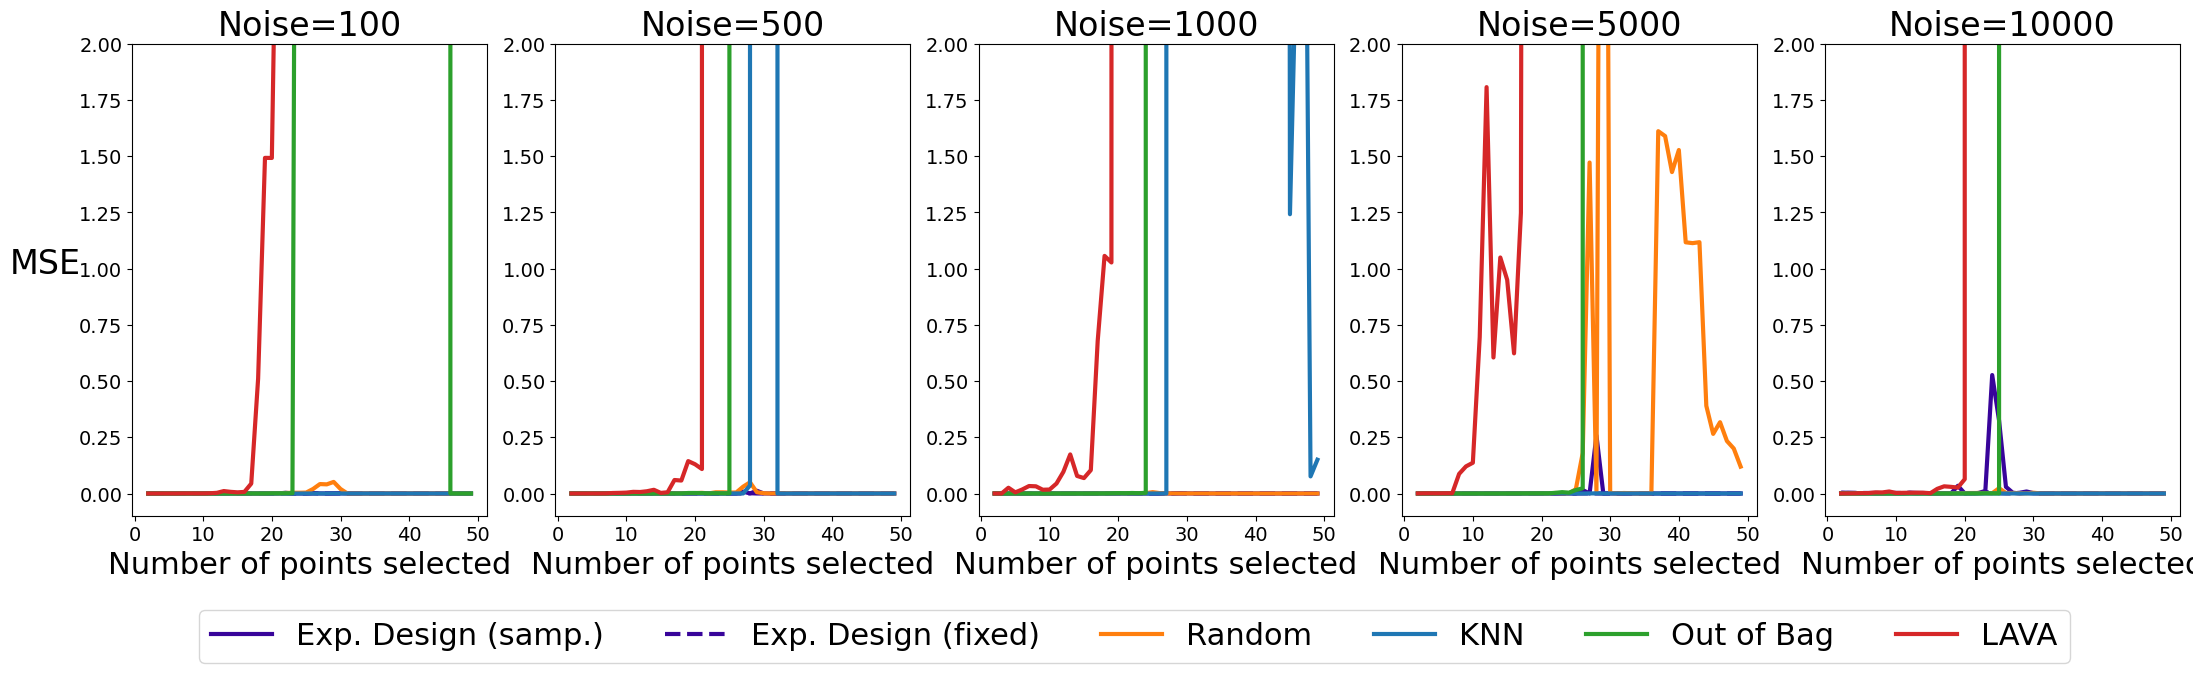

In [186]:
from pathlib import Path

fig_dir = Path("figures")

lw = 3
xrang = dict(
    zip(
        gauss_weight_res.keys(),
        (
            (0, 15),
            (0, 70),
            (0, 120),
            (0, 550),
        ),
    )
)
yrang = dict(
    zip(
        gauss_weight_res.keys(),
        (
            (-0.1, 3),
            (-0.1, 5),
            (-0.1, 7),
            (-0.1, 30),
        ),
    )
)

# fig, ax = plt.subplots(ncols=len(gauss_weight_res), figsize=(22, 6), sharey=True)
fig, ax = plt.subplots(
    ncols=len(gauss_weight_res),
    figsize=(22, 6),
)
for i, k in enumerate(gauss_weight_res.keys()):
    # if k == 500:
    # rang = np.arange(2, 550, 5)
    # else:
    # rang = np.arange(2, k + 50, 1)
    rang = np.arange(2, 50, 1)
    ax[i].set_title(f"Noise={k}", fontsize=24)
    ax[i].plot(
        rang, gauss_exp_errors[k], label=f"Exp. Design (samp.)", c=colors[0], lw=lw
    )
    ax[i].plot(
        rang,
        gauss_fix_errors[k],
        label=f"Exp. Design (fixed)",
        c=colors[0],
        ls="--",
        lw=lw,
    )
    ax[i].plot(rang, gauss_base_errors[k], label=f"Random", c="C1", ls="-", lw=lw)
    ax[i].plot(
        rang,
        gauss_knn_errors[k],
        label="KNN",
        c="C0",
        lw=lw,
    )
    ax[i].plot(rang, gauss_bag_errors[k], label=f"Out of Bag", c="C2", lw=lw)
    ax[i].plot(rang, gauss_lava_errors[k], label=f"LAVA", c="C3", lw=lw)
    # ax[i].set_xlim(*xrang[k])
    # ax[i].set_ylim(*yrang[k])
    # ax[i].set_xlim(0, 50)
    ax[i].set_ylim(-0.1, 2)
    # ax[i].set_ylim(-0.1, 1)
    ax[i].set_xlabel("Number of points selected", fontsize=22)
    ax[i].tick_params(labelsize=14)
    if i == 0:
        ax[i].set_ylabel("MSE", fontsize=24, rotation=0, labelpad=24)
        fig.legend(fontsize=22, bbox_to_anchor=(0.95, 0.0), ncols=6)
fig.tight_layout()
# plt.savefig(fig_dir / f'gaussian-vary-noise.eps', format='eps', bbox_inches='tight')
# plt.show()

In [140]:
exp_trials = 5
num_buyer = 10
reload(main_gaussian)

bone_buy_res = defaultdict(list)
bone_sell_res = defaultdict(list)
bone_val_res = defaultdict(list)
bone_weight_res = defaultdict(list)
bone_cond_res = defaultdict(list)
bone_norm_res = defaultdict(list)
bone_loss_res = defaultdict(list)
bone_coord_res = defaultdict(list)
bone_err_res = defaultdict(list)
# for k in [0, 1e-4, 1e-3, 1e-2, 1e-1, 1]:
# for k in [0, 1, 2, 3]:
for k in [0]:
    for i in range(exp_trials):
        x_sell, y_sell, x_val, y_val, x_buy, y_buy, beta = main_gaussian.get_data(
            num_seller=5000,
            num_buyer=num_buyer,
            dim=100,
            num_seller_subset=0,
            buyer_subset=False,
            noise_level=1,
            return_beta=True,
            random_seed=i,
            bone_data=True,
            cluster=False,
            n_clusters=50,
        )
        print(x_buy.shape)
        res = main_gaussian.design_selection(
            (x_sell, y_sell),
            (x_buy, y_buy),
            num_select=10,
            num_iters=100,
            alpha=0.1,
            # scale_cov=True,
            scale_cov=False,
        )
        bone_loss_res[k].append(res["losses"])
        # norm_res[k].append(res['norms'])
        # cond_res[k].append(res['conds'])
        bone_err_res[k].append(res["errors"])
        # coord_res[k].append(res['coords'])
        bone_weight_res[k].append(res["weights"])
        bone_buy_res[k].append((x_buy, y_buy))
        bone_sell_res[k].append((x_sell, y_sell))
        bone_val_res[k].append((x_val, y_val))

(10, 1000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.15it/s]


(10, 1000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.51it/s]


(10, 1000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.31it/s]


(10, 1000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.38it/s]


(10, 1000)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.29it/s]


In [141]:
base_trials = 1

bone_base_weights = defaultdict(list)
for k in bone_val_res.keys():
    for j, t in enumerate(range(base_trials)):
        print(t)

        baseline_values, baseline_runtimes = main_gaussian.get_baseline_values(
            *bone_sell_res[k][j],
            *bone_val_res[k][j],
            *bone_val_res[k][j],
            # *bone_buy_res[k][j],
            random_state=t,
            baselines={
                "DataOob": {"num_models": 100},
                "KNNShapley": {},
            }
        )
        bone_base_weights[k].append(baseline_values)

0
----------------DataOob-----------------


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


	TIME: 74
---------------KNNShapley---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:05<00:00, 936.99it/s]

	TIME: 9


In [142]:
import matplotlib

cmap = matplotlib.colormaps["plasma"].colors
colors = np.array(cmap)[np.linspace(20, 255, 5).astype(int)]

lw = 3
# use_ridge = True
use_ridge = False

rang = np.arange(2, 100)
for i, (k, v) in enumerate(bone_weight_res.items()):
    bone_exp_errors = np.mean(
        [
            [
                evaluate_subset(
                    np.random.choice(
                        np.arange(v[t].shape[0]), size=j, p=v[t], replace=False
                    ),
                    *bone_sell_res[k][t],
                    *bone_buy_res[k][t],
                    use_ridge=use_ridge,
                )
                for j in rang
            ]
            for t in range(exp_trials)
        ],
        0,
    )
    bone_base_errors = np.mean(
        [
            [
                evaluate_subset(
                    np.arange(j),
                    *bone_sell_res[k][t],
                    *bone_buy_res[k][t],
                    use_ridge=use_ridge,
                )
                for j in rang
            ]
            for t in range(exp_trials)
        ],
        0,
    )
    bone_knn_errors = np.mean(
        [
            [
                evaluate_subset(
                    bone_base_weights[k][t]["KNNShapley"].argsort()[::-1][:j],
                    *bone_sell_res[k][t],
                    *bone_buy_res[k][t],
                    use_ridge=use_ridge,
                )
                for j in rang
            ]
            for t in range(base_trials)
        ],
        0,
    )

    bone_bag_errors = np.mean(
        [
            [
                evaluate_subset(
                    bone_base_weights[k][t]["DataOob"].argsort()[::-1][:j],
                    *bone_sell_res[k][t],
                    *bone_buy_res[k][t],
                    use_ridge=use_ridge,
                )
                for j in rang
            ]
            for t in range(base_trials)
        ],
        0,
    )

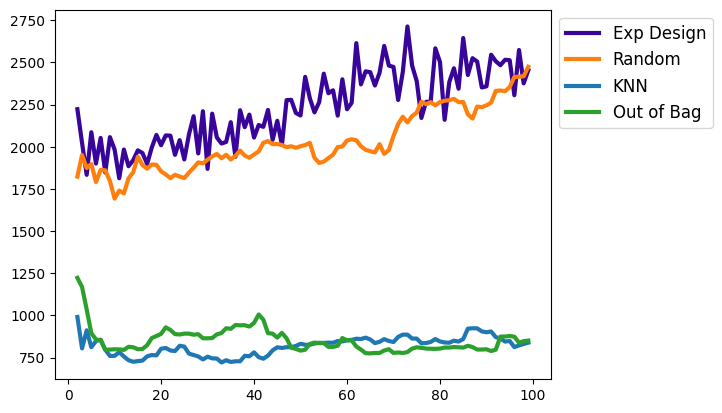

In [143]:
plt.plot(rang, bone_exp_errors, label=f"Exp Design", c=colors[i], lw=lw)
plt.plot(rang, bone_base_errors, label=f"Random", c="C1", ls="-", lw=lw)
plt.plot(
    rang,
    bone_knn_errors,
    label="KNN",
    c="C0",
    lw=lw,
)
plt.plot(rang, bone_bag_errors, label=f"Out of Bag", c="C2", lw=lw)
plt.legend(fontsize=12, bbox_to_anchor=(1, 1))

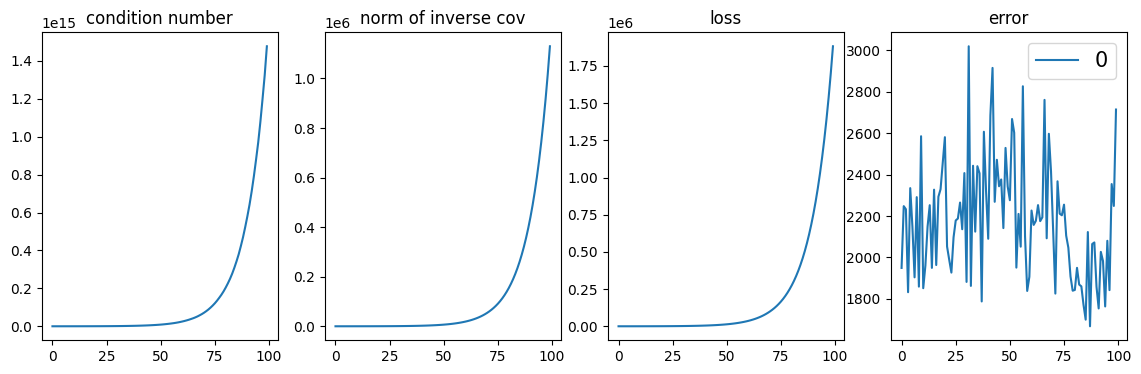

In [102]:
fig, ax = plt.subplots(ncols=4, figsize=(14, 4))
for x in loss_res.keys():
    # for x in alphas[:-1]:
    # for x in iters:
    ax[0].plot(
        cond_res[x][0].keys(),
        np.mean([list(x_i.values()) for x_i in cond_res[x]], 0),
        label=x,
    )
    ax[1].plot(
        norm_res[x][0].keys(),
        np.mean([list(x_i.values()) for x_i in norm_res[x]], 0),
        label=x,
    )
    ax[2].plot(
        loss_res[x][0].keys(),
        np.mean([list(x_i.values()) for x_i in loss_res[x]], 0),
        label=x,
    )
    ax[3].plot(
        err_res[x][0].keys(),
        np.mean([list(x_i.values()) for x_i in err_res[x]], 0),
        label=x,
    )
ax[0].set_title("condition number")
ax[1].set_title("norm of inverse cov")
ax[2].set_title("loss")
ax[3].set_title("error")

plt.legend(fontsize=15)

In [685]:
j = 10
random_err = []
design_err = []
for i in range(trials):
    random_err.append(
        evaluate_subset(
            np.random.choice(range(x_sell.shape[0]), size=10),
            *sell_res["a"][i],
            *buy_res["a"][i]
        )
    )
    design_err.append(
        evaluate_subset(
            res["weights"].argsort()[-j:], *sell_res["a"][i], *buy_res["a"][i]
        )
    )
print(np.mean(random_err))
print(np.mean(design_err))

104.30881911767419
99.31677910022974


In [636]:
x_sell.shape

(510, 1000)

In [655]:
# initialize seller weights
n_sell = x_sell.shape[0]
weights = np.ones(n_sell) / n_sell
alpha = 0.1
# weights /= (1 - alpha)
# weights[84] += alpha
X = x_sell
X -= x_sell.mean(0)
inv_cov = np.linalg.pinv(X.T @ (np.diag(weights)) @ X)
# inv_cov = np.eye(x_sell.shape[1])

loss = frank_wolfe.compute_exp_design_loss(x_buy, inv_cov)

neg_grad = frank_wolfe.compute_neg_gradient(X, x_buy, inv_cov)
update_coord = np.argmax(neg_grad)
print(update_coord)
np.mean((x_buy @ inv_cov @ X.T) ** 2, 0).argsort()

113


array([434, 369, 484, 135, 487,  72, 316, 496, 334, 386, 138, 169, 415,
       412,  75,  29, 347, 148, 222, 419,  36,  49, 242, 431, 143,  18,
       208, 377,  25, 306,  46, 479, 438, 172,  26, 193, 234,  28, 397,
       404, 353, 106,  83, 379,  65, 218,  62,  88, 423, 319, 364, 362,
       221, 481, 318, 352, 499,  97, 247,  37, 383, 130, 295, 339,  71,
       363, 449, 145, 371, 303,  13, 451,  95, 457,  76, 155, 439, 165,
       474, 473, 240, 476, 463, 317, 443, 271, 302, 309, 220,   5, 392,
        61, 436, 394, 414, 420, 262, 440, 141, 297, 178, 188, 132, 154,
         3,  58, 337, 161, 338, 356,  99, 124, 214, 173, 196,  16, 471,
       344, 104, 467, 235,  11, 152, 462, 450,  92, 265,  98, 493,  21,
       195, 345,  81,  24, 465, 112, 416, 374,   0, 292, 357, 239, 360,
       179, 174,  17, 187, 149, 198,  43, 495, 407, 489, 162, 314, 376,
        42, 370,  96, 251,  90, 245, 454, 358, 213,  55,  15, 139, 389,
        51, 248, 129, 411, 448, 115, 400, 299,  69, 127, 308, 45

In [42]:
best

{14, 19, 40, 54, 66, 70, 74}

In [461]:
k = [38, 81]
# k = [51, 72]
# k = [36, 81]
x_k = x_sell[k]
y_k = y_sell[k]
proj_sell = x_k.T @ np.linalg.pinv(x_k @ x_k.T) @ x_k
proj_buy = x_buy.T @ np.linalg.pinv(x_buy @ x_buy.T) @ x_buy
print(np.mean(np.linalg.norm(x_buy @ proj_sell, axis=1)))
print(np.mean(np.linalg.norm(x_k @ proj_buy, axis=1)))

0.11652863887371805
0.279346642389638


In [462]:
np.linalg.norm(frank_wolfe.least_norm_linear_regression(x_k, y_k) - beta)

13.828745009964125

In [463]:
X = np.concatenate([x_buy[:], x_sell])
P = np.linalg.pinv(X.T @ X)
np.linalg.norm(x_buy @ P @ X.T, axis=0).argsort()
np.linalg.norm(x_buy @ X.T, axis=0).argsort()

array([535, 299, 710, ...,   8,   5,   7])

In [1100]:
np.linalg.norm(x_buy @ x_sell.T, axis=0).argsort()

array([69, 30, 95, 59, 25, 36, 80, 81,  8, 11, 70, 66, 86, 92, 18, 47, 83,
        0, 84,  7, 38, 75, 14, 23, 97, 58, 10, 99, 21, 65, 34, 48, 78, 89,
       87, 94, 82, 12, 57,  1, 93, 55, 56,  9, 40, 28, 13, 63, 90,  5, 91,
       35, 61, 67, 27, 24, 39, 76, 71, 96, 52, 16, 19,  4, 37, 17, 46, 42,
       20, 43, 54, 77, 88, 73, 62, 33,  2,  3, 50, 22, 98, 41, 60, 85, 53,
       44, 64, 32, 79,  6, 26, 29, 68, 49, 45, 15, 74, 31, 51, 72])

In [1088]:
w = np.diag(np.ones(x_sell.shape[0]))
w[0, 0] = 0.9
w[1, 1] = 0.9
# w[2, 2] = 0.9
# w / w.sum()
P = np.linalg.inv(x_sell.T @ w @ x_sell)
frank_wolfe.compute_exp_design_loss(x_buy, P)

0.12939651497204313